# SAE Latent Features vs. Graph Motifs Correspondence Analysis

This notebook analyzes whether individual SAE latent features correspond to canonical graph motifs.

**Approach:**
- Use ONLY test set (500 graphs, ~40K nodes)
- Extract 512-dimensional latent representations for each node using trained SAE
- Analyze correlation between latent features (z1-z512) and motif membership labels
- Compute point-biserial correlation, precision/recall, and mutual information
- Identify interpretable (rpb > 0.5) and monosemantic (rpb > 0.7) features

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pointbiserialr
from sklearn.metrics import mutual_info_score
import torch
import torch.nn as nn
import torch.nn.functional as F

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 1. Load SAE Model and Test Graph IDs

In [2]:
# Define SAE architecture (must match training)
class SparseAutoencoder(nn.Module):
    """Sparse Autoencoder with TopK sparsity."""
    
    def __init__(self, input_dim: int = 64, latent_dim: int = 512, k: int = 32):
        super(SparseAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.k = k
        
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode with TopK sparsity."""
        z = self.encoder(x)
        z = F.relu(z)
        
        if self.k < self.latent_dim:
            topk_values, topk_indices = torch.topk(z, self.k, dim=1)
            z_sparse = torch.zeros_like(z)
            z_sparse.scatter_(1, topk_indices, topk_values)
            return z_sparse
        return z
    
    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decoder(z)
        return x_hat, z

# Load trained SAE model
model = SparseAutoencoder(input_dim=64, latent_dim=512, k=32)
checkpoint = torch.load('checkpoints/sae_model.pt', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✓ Loaded trained SAE model")
print(f"  Architecture: {model.input_dim} -> {model.latent_dim} -> {model.input_dim}")
print(f"  Sparsity: TopK with k={model.k} ({100*model.k/model.latent_dim:.2f}% active)")

✓ Loaded trained SAE model
  Architecture: 64 -> 512 -> 64
  Sparsity: TopK with k=32 (6.25% active)


In [3]:
# Load test graph IDs
with open('outputs/test_graph_ids.json', 'r') as f:
    test_graph_ids = json.load(f)['graph_ids']

print(f"\n✓ Loaded {len(test_graph_ids)} test graph IDs")
print(f"  Range: {min(test_graph_ids)} to {max(test_graph_ids)}")


✓ Loaded 500 test graph IDs
  Range: 5 to 4994


## 2. Extract SAE Latent Representations for Test Nodes

In [4]:
# Extract latent representations for all test nodes
activation_dir = Path("outputs/activations/layer2/test")
metadata_dir = Path("virtual_graphs/data/all_graphs/graph_motif_metadata")

all_latents = []  # Will store (graph_id, node_idx, z1, z2, ..., z512)
all_motifs = []   # Will store motif labels for each node

print("Extracting SAE latent representations for test nodes...")
print(f"Reading from: {activation_dir}")
print(f"Metadata from: {metadata_dir}\n")

for graph_id in tqdm(test_graph_ids, desc="Processing test graphs"):
    # Load layer2 activations for this graph
    act_file = activation_dir / f"graph_{graph_id}.pt"
    if not act_file.exists():
        print(f"Warning: Missing activation file for graph {graph_id}")
        continue
    
    activations = torch.load(act_file, weights_only=True)  # [num_nodes, 64]
    
    # Extract latent representations using SAE encoder
    with torch.no_grad():
        latents = model.encode(activations)  # [num_nodes, 512]
    
    latents_np = latents.numpy()  # [num_nodes, 512]
    num_nodes = latents_np.shape[0]
    
    # Load motif metadata for this graph
    metadata_file = metadata_dir / f"graph_{graph_id}_metadata.csv"
    if not metadata_file.exists():
        print(f"Warning: Missing metadata for graph {graph_id}")
        continue
    
    df_meta = pd.read_csv(metadata_file, index_col=0)
    
    # Verify node count matches
    if len(df_meta) != num_nodes:
        print(f"Warning: Node count mismatch for graph {graph_id}: {num_nodes} vs {len(df_meta)}")
        continue
    
    # Store latents with graph_id and node_idx
    for node_idx in range(num_nodes):
        latent_row = [graph_id, node_idx] + latents_np[node_idx].tolist()
        all_latents.append(latent_row)
        
        # Store motif labels for this node
        motif_row = df_meta.iloc[node_idx].to_dict()
        motif_row['graph_id'] = graph_id
        motif_row['node_idx'] = node_idx
        all_motifs.append(motif_row)

# Convert to DataFrame
latent_cols = ['graph_id', 'node_idx'] + [f'z{i+1}' for i in range(512)]
df_latents = pd.DataFrame(all_latents, columns=latent_cols)

df_motifs = pd.DataFrame(all_motifs)

print(f"\n✓ Extracted latent representations for {len(df_latents)} nodes")
print(f"  Latent features shape: {df_latents.shape}")
print(f"  Motif labels shape: {df_motifs.shape}")

Extracting SAE latent representations for test nodes...
Reading from: outputs/activations/layer2/test
Metadata from: virtual_graphs/data/all_graphs/graph_motif_metadata



Processing test graphs:   0%|          | 0/500 [00:00<?, ?it/s]

Processing test graphs: 100%|██████████| 500/500 [00:01<00:00, 358.59it/s]



✓ Extracted latent representations for 5000 nodes
  Latent features shape: (5000, 514)
  Motif labels shape: (5000, 6)


In [5]:
# Merge latents and motifs into single dataframe
df = pd.merge(df_latents, df_motifs, on=['graph_id', 'node_idx'])

print(f"\n✓ Merged dataset: {df.shape}")
print(f"\nMotif types found in metadata:")
motif_types = [col for col in df.columns if col.startswith('in_') or col in ['feedforward_loop', 'feedback_loop', 'single_input_module', 'cascade']]
print(f"  {motif_types}")

# Standardize column names if needed
if 'feedforward_loop' in df.columns:
    df = df.rename(columns={
        'feedforward_loop': 'in_feedforward_loop',
        'feedback_loop': 'in_feedback_loop',
        'single_input_module': 'in_single_input_module',
        'cascade': 'in_cascade'
    })

motif_types = ['in_feedforward_loop', 'in_feedback_loop', 'in_single_input_module', 'in_cascade']

print(f"\nMotif distribution in test set:")
for motif in motif_types:
    if motif in df.columns:
        count = df[motif].sum()
        pct = 100 * count / len(df)
        print(f"  {motif}: {count} nodes ({pct:.2f}%)")

# Display sample
print(f"\nSample of merged dataset:")
display_cols = ['graph_id', 'node_idx', 'z1', 'z2', 'z3', 'z511', 'z512'] + motif_types
print(df[display_cols].head())


✓ Merged dataset: (5000, 518)

Motif types found in metadata:
  ['feedforward_loop', 'feedback_loop', 'single_input_module', 'cascade']

Motif distribution in test set:
  in_feedforward_loop: 1116 nodes (22.32%)
  in_feedback_loop: 1164 nodes (23.28%)
  in_single_input_module: 1109 nodes (22.18%)
  in_cascade: 968 nodes (19.36%)

Sample of merged dataset:
   graph_id  node_idx   z1   z2   z3  z511  z512  in_feedforward_loop  \
0      4367         0  0.0  0.0  0.0   0.0   0.0                    1   
1      4367         1  0.0  0.0  0.0   0.0   0.0                    1   
2      4367         2  0.0  0.0  0.0   0.0   0.0                    1   
3      4367         3  0.0  0.0  0.0   0.0   0.0                    0   
4      4367         4  0.0  0.0  0.0   0.0   0.0                    0   

   in_feedback_loop  in_single_input_module  in_cascade  
0                 0                       0           0  
1                 0                       0           0  
2                 0         

## 3. Point-Biserial Correlation Analysis

Compute correlation between each SAE latent feature (z1-z512) and binary motif labels.

$$r_{pb}(z_j, m) = \frac{\bar{z}_1 - \bar{z}_0}{s_z} \sqrt{\frac{n_1 n_0}{n^2}}$$

Where:
- $\bar{z}_1$: mean activation when motif is present
- $\bar{z}_0$: mean activation when motif is absent
- $s_z$: standard deviation of feature
- $n_1, n_0$: counts in each group

In [6]:
# Compute point-biserial correlation for all feature-motif pairs
latent_features = [f'z{i+1}' for i in range(512)]

correlations = []

print("Computing point-biserial correlations...")
for motif in tqdm(motif_types, desc="Motif types"):
    if motif not in df.columns:
        continue
    
    for z_idx, z_col in enumerate(latent_features):
        # Compute point-biserial correlation
        corr, pval = pointbiserialr(df[motif], df[z_col])
        
        correlations.append({
            'feature': z_col,
            'feature_idx': z_idx + 1,
            'motif': motif,
            'rpb': corr,
            'pval': pval,
            'rpb_abs': abs(corr)
        })

df_corr = pd.DataFrame(correlations)

print(f"\n✓ Computed {len(df_corr)} correlations ({len(latent_features)} features × {len(motif_types)} motifs)")
print(f"\nCorrelation statistics:")
print(df_corr[['rpb', 'rpb_abs', 'pval']].describe())

Computing point-biserial correlations...


Motif types:   0%|          | 0/4 [00:00<?, ?it/s]/data/users/goodarzilab/shervin/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5655: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
Motif types: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


✓ Computed 2048 correlations (512 features × 4 motifs)

Correlation statistics:
              rpb     rpb_abs          pval
count  624.000000  624.000000  6.240000e+02
mean    -0.002357    0.015667  4.147999e-01
std      0.021080    0.014287  2.912442e-01
min     -0.093109    0.000027  5.296589e-16
25%     -0.012794    0.006930  1.305904e-01
50%     -0.004175    0.011163  4.300287e-01
75%      0.009564    0.021383  6.241967e-01
max      0.114268    0.114268  9.984975e-01


In [7]:
# Pivot to create feature-motif correlation matrix
corr_matrix = df_corr.pivot(index='feature', columns='motif', values='rpb')

print("Feature-Motif Correlation Matrix (rpb):")
print(corr_matrix.head(10))

# Save full correlation matrix
corr_matrix.to_csv('outputs/feature_motif_correlations.csv')
print(f"\n✓ Saved full correlation matrix to outputs/feature_motif_correlations.csv")

Feature-Motif Correlation Matrix (rpb):
motif    in_cascade  in_feedback_loop  in_feedforward_loop  \
feature                                                      
z1        -0.006930          0.025676            -0.007581   
z10             NaN               NaN                  NaN   
z100            NaN               NaN                  NaN   
z101            NaN               NaN                  NaN   
z102            NaN               NaN                  NaN   
z103       0.030967          0.031207            -0.013237   
z104            NaN               NaN                  NaN   
z105      -0.006930         -0.007791            -0.007581   
z106      -0.004497         -0.014220             0.003696   
z107            NaN               NaN                  NaN   

motif    in_single_input_module  
feature                          
z1                    -0.007551  
z10                         NaN  
z100                        NaN  
z101                        NaN  
z102       

## 4. Identify Interpretable and Monosemantic Features

**Interpretable feature:** rpb > 0.5 for one motif, rpb < 0.2 for all others

**Monosemantic feature:** rpb > 0.7 for one motif, rpb < 0.2 for all others

In [8]:
# Identify interpretable and monosemantic features
INTERPRETABLE_THRESHOLD = 0.5
MONOSEMANTIC_THRESHOLD = 0.7
OTHER_MOTIF_THRESHOLD = 0.2

interpretable_features = []
monosemantic_features = []

# Count features with valid correlations
valid_features = 0

for feature in latent_features:
    feature_corrs = corr_matrix.loc[feature].abs()
    
    # Skip features with all NaN correlations (never activated)
    if feature_corrs.isna().all():
        continue
    
    valid_features += 1
    
    # Get max correlation (ignoring NaN)
    max_corr = feature_corrs.max(skipna=True)
    max_motif = feature_corrs.idxmax(skipna=True)
    
    # Skip if max is still NaN
    if pd.isna(max_corr) or pd.isna(max_motif):
        continue
    
    # Check other motifs
    other_corrs = feature_corrs.drop(max_motif)
    max_other = other_corrs.max(skipna=True)
    
    # Handle case where other correlations might all be NaN
    if pd.isna(max_other):
        max_other = 0.0
    
    # Interpretable: max > 0.5 and others < 0.2
    if max_corr > INTERPRETABLE_THRESHOLD and max_other < OTHER_MOTIF_THRESHOLD:
        interpretable_features.append({
            'feature': feature,
            'motif': max_motif,
            'rpb': corr_matrix.loc[feature, max_motif],
            'rpb_abs': max_corr,
            'max_other_rpb': max_other
        })
        
        # Monosemantic: max > 0.7 and others < 0.2
        if max_corr > MONOSEMANTIC_THRESHOLD:
            monosemantic_features.append({
                'feature': feature,
                'motif': max_motif,
                'rpb': corr_matrix.loc[feature, max_motif],
                'rpb_abs': max_corr,
                'max_other_rpb': max_other
            })

df_interpretable = pd.DataFrame(interpretable_features)
df_monosemantic = pd.DataFrame(monosemantic_features)

print("=" * 60)
print("INTERPRETABILITY ANALYSIS")
print("=" * 60)
print(f"\nTotal features: {len(latent_features)}")
print(f"Features with valid correlations: {valid_features} ({100*valid_features/len(latent_features):.1f}%)")
print(f"Features never activated (all NaN): {len(latent_features) - valid_features}")
print(f"\nInterpretable features (rpb > {INTERPRETABLE_THRESHOLD}, others < {OTHER_MOTIF_THRESHOLD}): {len(df_interpretable)}")
print(f"Monosemantic features (rpb > {MONOSEMANTIC_THRESHOLD}, others < {OTHER_MOTIF_THRESHOLD}): {len(df_monosemantic)}")

if len(df_interpretable) > 0:
    print(f"\nInterpretable features by motif:")
    print(df_interpretable.groupby('motif').size())

if len(df_monosemantic) > 0:
    print(f"\nMonosemantic features by motif:")
    print(df_monosemantic.groupby('motif').size())
    
    print(f"\nTop monosemantic features:")
    print(df_monosemantic.sort_values('rpb_abs', ascending=False).head(10))
else:
    print(f"\nNo monosemantic features found with current thresholds.")
    print(f"This suggests the SAE features may not have strong one-to-one correspondence with motifs.")

INTERPRETABILITY ANALYSIS

Total features: 512
Features with valid correlations: 156 (30.5%)
Features never activated (all NaN): 356

Interpretable features (rpb > 0.5, others < 0.2): 0
Monosemantic features (rpb > 0.7, others < 0.2): 0

No monosemantic features found with current thresholds.
This suggests the SAE features may not have strong one-to-one correspondence with motifs.


## 5. Precision and Recall Analysis

$$\text{Precision} = \frac{\#\text{ nodes where } (z_j > \tau) \text{ and motif present}}{\#\text{ nodes where } (z_j > \tau)}$$

$$\text{Recall} = \frac{\#\text{ nodes where } (z_j > \tau) \text{ and motif present}}{\#\text{ nodes with motif present}}$$

where $\tau$ is the 95th percentile activation threshold.

In [9]:
def compute_precision_recall(df, feature, motif, percentile=95):
    """Compute precision and recall for a feature-motif pair."""
    # Threshold at specified percentile
    threshold = np.percentile(df[feature], percentile)
    
    # Nodes where feature is highly activated
    activated = df[feature] > threshold
    
    # Nodes where motif is present
    present = df[motif] == 1
    
    # True positives
    tp = (activated & present).sum()
    
    # Precision and recall
    precision = tp / activated.sum() if activated.sum() > 0 else 0
    recall = tp / present.sum() if present.sum() > 0 else 0
    
    return precision, recall, threshold

# Compute precision/recall for top correlated features
precision_recall_results = []

print("Computing precision and recall for top features...")

# For each motif, get top 10 features by absolute correlation
for motif in motif_types:
    if motif not in df.columns:
        continue
    
    motif_corrs = df_corr[df_corr['motif'] == motif].nlargest(10, 'rpb_abs')
    
    for _, row in motif_corrs.iterrows():
        feature = row['feature']
        precision, recall, threshold = compute_precision_recall(df, feature, motif)
        
        precision_recall_results.append({
            'feature': feature,
            'motif': motif,
            'rpb': row['rpb'],
            'precision': precision,
            'recall': recall,
            'threshold': threshold,
            'f1_score': 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        })

df_pr = pd.DataFrame(precision_recall_results)

print(f"\n✓ Computed precision/recall for {len(df_pr)} feature-motif pairs")
print(f"\nPrecision/Recall statistics:")
print(df_pr[['precision', 'recall', 'f1_score']].describe())

print(f"\nTop 10 by F1 score:")
print(df_pr.nlargest(10, 'f1_score')[['feature', 'motif', 'rpb', 'precision', 'recall', 'f1_score']])

Computing precision and recall for top features...

✓ Computed precision/recall for 40 feature-motif pairs

Precision/Recall statistics:
       precision     recall   f1_score
count  40.000000  40.000000  40.000000
mean    0.259183   0.041157   0.067667
std     0.181433   0.027038   0.043843
min     0.037037   0.000896   0.001750
25%     0.144000   0.020191   0.033113
50%     0.225347   0.037929   0.061124
75%     0.350000   0.064390   0.103075
max     1.000000   0.096220   0.158416

Top 10 by F1 score:
   feature                motif       rpb  precision    recall  f1_score
10    z496     in_feedback_loop  0.114268      0.448  0.096220  0.158416
11    z145     in_feedback_loop  0.100054      0.404  0.086770  0.142857
16    z307     in_feedback_loop  0.058770      0.376  0.080756  0.132956
15    z316     in_feedback_loop  0.064127      0.360  0.077320  0.127298
13     z77     in_feedback_loop  0.077788      0.356  0.076460  0.125884
18    z509     in_feedback_loop  0.045992      0.348 

## 6. Mutual Information Analysis

$$I(z_j; m) = H(m) - H(m|z_j)$$

Captures nonlinear dependencies between features and motifs.

In [10]:
# Compute mutual information
mi_results = []

print("Computing mutual information...")

for motif in tqdm(motif_types, desc="Motif types"):
    if motif not in df.columns:
        continue
    
    for z_col in latent_features:
        # Discretize continuous latent feature into bins
        z_discrete = pd.cut(df[z_col], bins=10, labels=False)
        
        # Compute mutual information
        mi = mutual_info_score(df[motif], z_discrete)
        
        mi_results.append({
            'feature': z_col,
            'motif': motif,
            'mutual_info': mi
        })

df_mi = pd.DataFrame(mi_results)

print(f"\n✓ Computed {len(df_mi)} mutual information scores")
print(f"\nMutual Information statistics:")
print(df_mi['mutual_info'].describe())

# Pivot to matrix form
mi_matrix = df_mi.pivot(index='feature', columns='motif', values='mutual_info')
mi_matrix.to_csv('outputs/feature_motif_mutual_info.csv')
print(f"\n✓ Saved MI matrix to outputs/feature_motif_mutual_info.csv")

Computing mutual information...


Motif types: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


✓ Computed 2048 mutual information scores

Mutual Information statistics:
count    2048.000000
mean        0.000595
std         0.002142
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000350
max         0.027068
Name: mutual_info, dtype: float64

✓ Saved MI matrix to outputs/feature_motif_mutual_info.csv


## 7. Visualizations

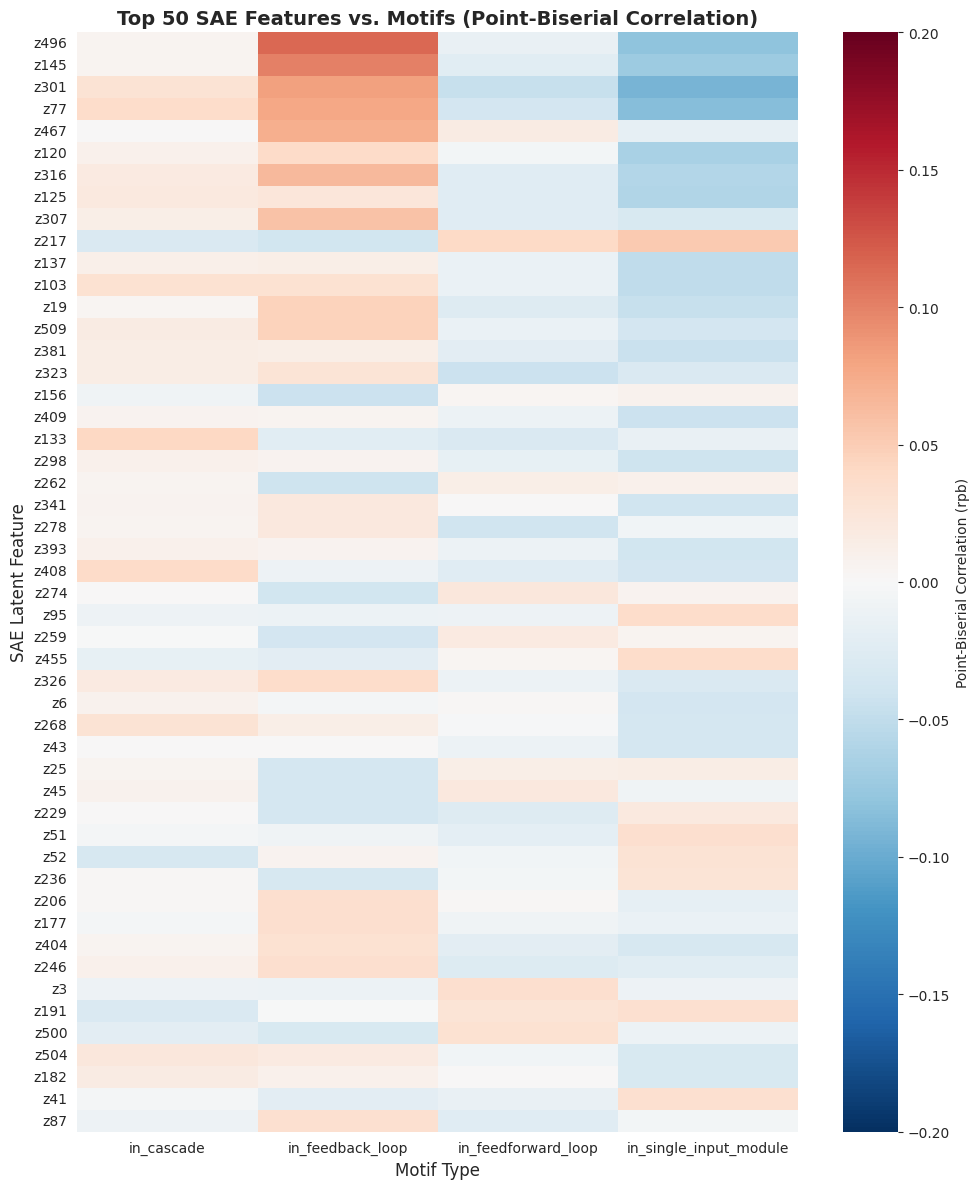

In [20]:
# Plot 1: Correlation heatmap for top features
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Get top 50 features by max absolute correlation
max_corrs = corr_matrix.abs().max(axis=1)
top_features = max_corrs.nlargest(50).index

# Plot heatmap
sns.heatmap(corr_matrix.loc[top_features], 
            cmap='RdBu_r', center=0, vmin=-0.2, vmax=0.2,
            cbar_kws={'label': 'Point-Biserial Correlation (rpb)'},
            ax=ax)
ax.set_title('Top 50 SAE Features vs. Motifs (Point-Biserial Correlation)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Motif Type', fontsize=12)
ax.set_ylabel('SAE Latent Feature', fontsize=12)

plt.tight_layout()
plt.savefig('outputs/feature_motif_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

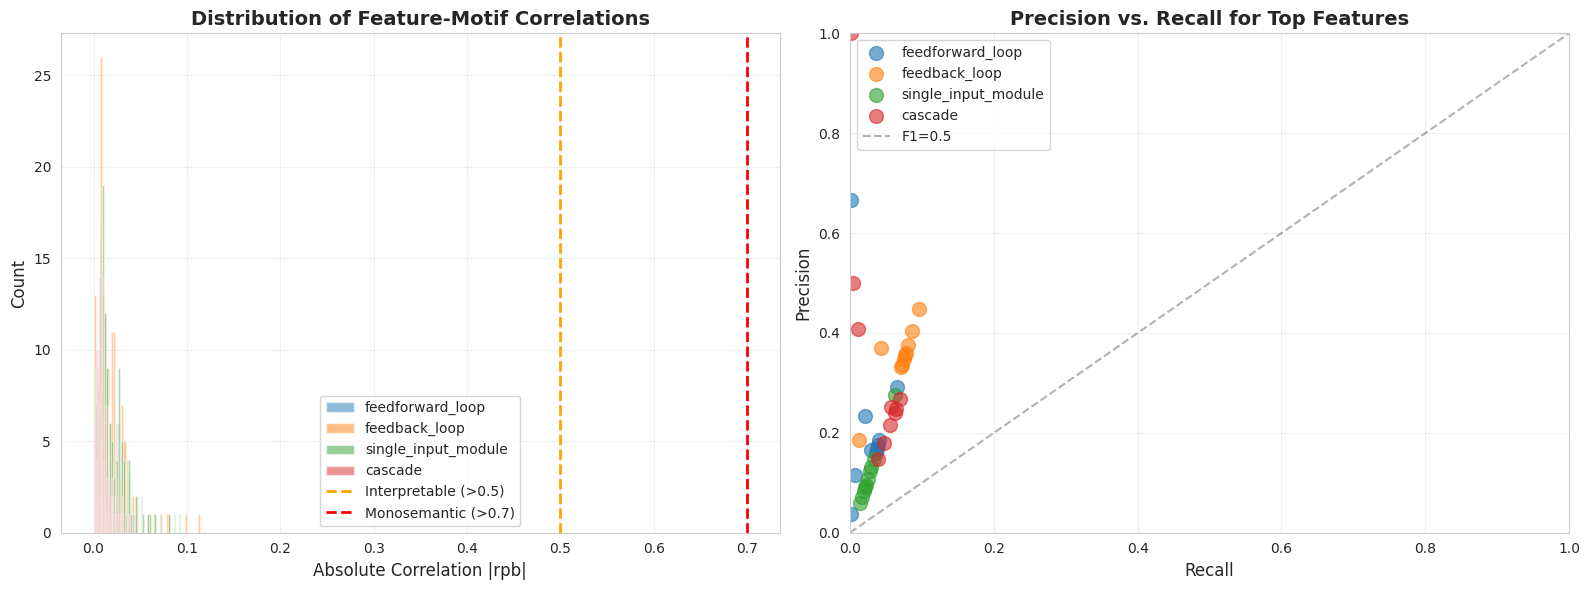

In [12]:
# Plot 2: Distribution of correlation strengths
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Histogram of absolute correlations
ax = axes[0]
for motif in motif_types:
    if motif in df_corr['motif'].values:
        motif_corrs = df_corr[df_corr['motif'] == motif]['rpb_abs']
        ax.hist(motif_corrs, bins=50, alpha=0.5, label=motif.replace('in_', ''))

ax.axvline(x=INTERPRETABLE_THRESHOLD, color='orange', linestyle='--', 
           linewidth=2, label=f'Interpretable (>{INTERPRETABLE_THRESHOLD})')
ax.axvline(x=MONOSEMANTIC_THRESHOLD, color='red', linestyle='--', 
           linewidth=2, label=f'Monosemantic (>{MONOSEMANTIC_THRESHOLD})')
ax.set_xlabel('Absolute Correlation |rpb|', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Feature-Motif Correlations', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right: Precision vs Recall scatter
ax = axes[1]
for motif in motif_types:
    motif_pr = df_pr[df_pr['motif'] == motif]
    ax.scatter(motif_pr['recall'], motif_pr['precision'], 
              alpha=0.6, s=100, label=motif.replace('in_', ''))

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='F1=0.5')
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision vs. Recall for Top Features', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('outputs/correlation_distribution_and_precision_recall.png', dpi=150, bbox_inches='tight')
plt.show()

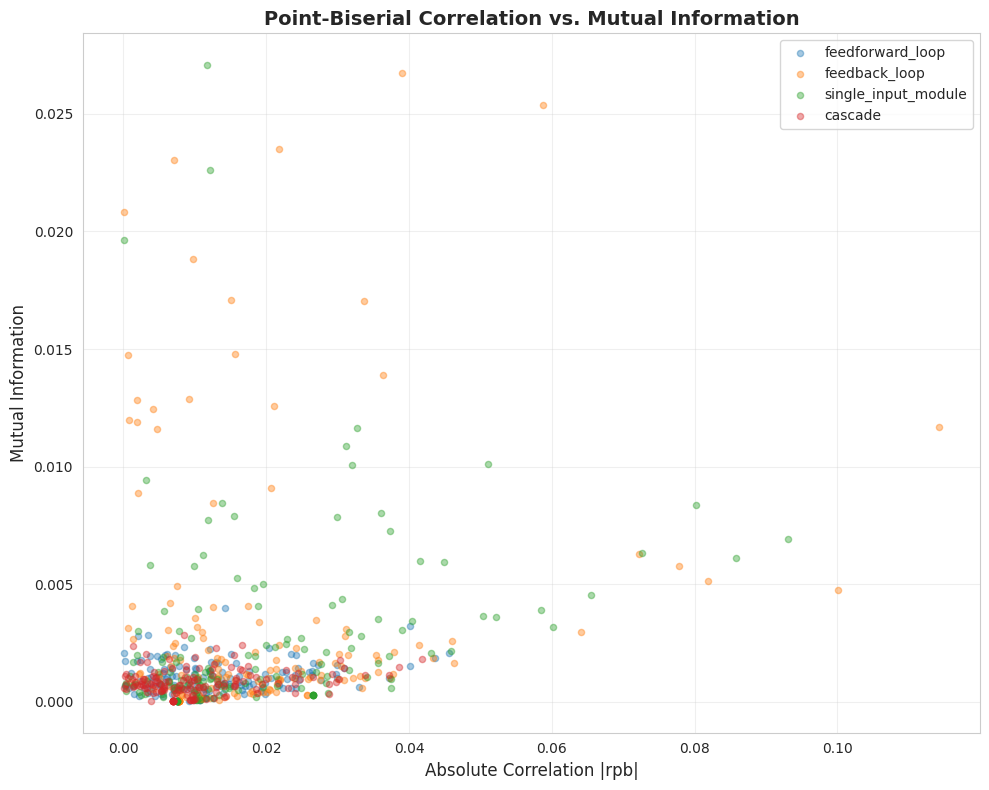

In [13]:
# Plot 3: Correlation vs Mutual Information scatter
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Merge correlation and MI data
df_combined = pd.merge(df_corr, df_mi, on=['feature', 'motif'])

for motif in motif_types:
    motif_data = df_combined[df_combined['motif'] == motif]
    ax.scatter(motif_data['rpb_abs'], motif_data['mutual_info'], 
              alpha=0.4, s=20, label=motif.replace('in_', ''))

ax.set_xlabel('Absolute Correlation |rpb|', fontsize=12)
ax.set_ylabel('Mutual Information', fontsize=12)
ax.set_title('Point-Biserial Correlation vs. Mutual Information', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/correlation_vs_mutual_info.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Plot 4: Feature activation distributions for monosemantic features
if len(df_monosemantic) > 0:
    # Plot top 4 monosemantic features
    top_mono = df_monosemantic.nlargest(4, 'rpb_abs')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for idx, (_, row) in enumerate(top_mono.iterrows()):
        if idx >= 4:
            break
            
        ax = axes[idx]
        feature = row['feature']
        motif = row['motif']
        rpb = row['rpb']
        
        # Plot activation distribution split by motif presence
        motif_present = df[df[motif] == 1][feature]
        motif_absent = df[df[motif] == 0][feature]
        
        ax.hist(motif_absent, bins=50, alpha=0.5, label='Motif Absent', color='gray')
        ax.hist(motif_present, bins=50, alpha=0.7, label='Motif Present', color='red')
        
        ax.set_xlabel(f'{feature} Activation', fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.set_title(f'{feature} for {motif.replace("in_", "")}\nrpb = {rpb:.3f}', 
                     fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('outputs/monosemantic_feature_activations.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No monosemantic features found to visualize.")

No monosemantic features found to visualize.


### Additional Visualizations

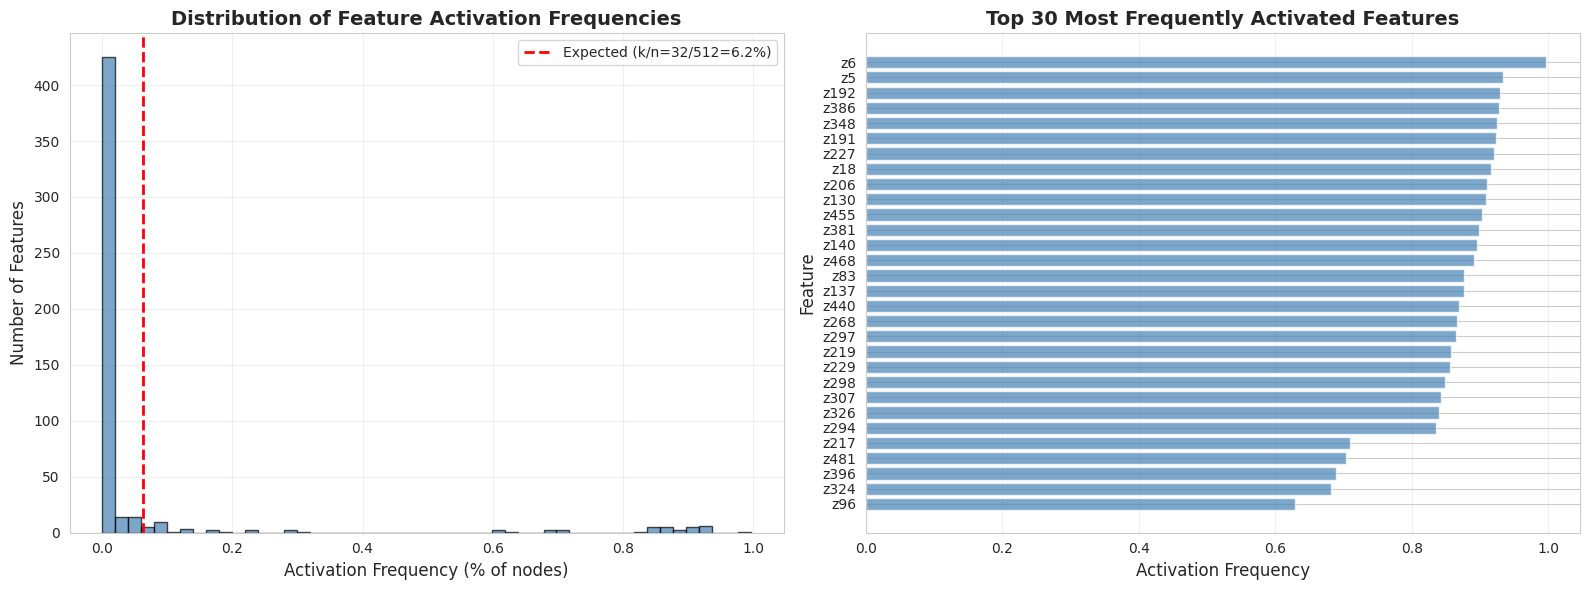


Feature Activation Statistics:
  Mean activation freq: 0.062
  Median activation freq: 0.000
  Features never activated: 356


In [15]:
# Plot 5: Feature Activation Frequency
# Show which features are most frequently activated across the dataset
feature_activation_freq = []
for z_col in latent_features:
    activated_count = (df[z_col] > 0).sum()
    freq = activated_count / len(df)
    feature_activation_freq.append({
        'feature': z_col,
        'activation_count': activated_count,
        'activation_freq': freq
    })

df_activation = pd.DataFrame(feature_activation_freq)
df_activation = df_activation.sort_values('activation_freq', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Histogram of activation frequencies
ax = axes[0]
ax.hist(df_activation['activation_freq'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(x=model.k/model.latent_dim, color='red', linestyle='--', 
           linewidth=2, label=f'Expected (k/n={model.k}/{model.latent_dim}={100*model.k/model.latent_dim:.1f}%)')
ax.set_xlabel('Activation Frequency (% of nodes)', fontsize=12)
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Distribution of Feature Activation Frequencies', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right: Top 30 most frequently activated features
ax = axes[1]
top_30 = df_activation.head(30)
ax.barh(range(len(top_30)), top_30['activation_freq'], color='steelblue', alpha=0.7)
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels(top_30['feature'])
ax.set_xlabel('Activation Frequency', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Top 30 Most Frequently Activated Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('outputs/feature_activation_frequency.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFeature Activation Statistics:")
print(f"  Mean activation freq: {df_activation['activation_freq'].mean():.3f}")
print(f"  Median activation freq: {df_activation['activation_freq'].median():.3f}")
print(f"  Features never activated: {(df_activation['activation_freq'] == 0).sum()}")

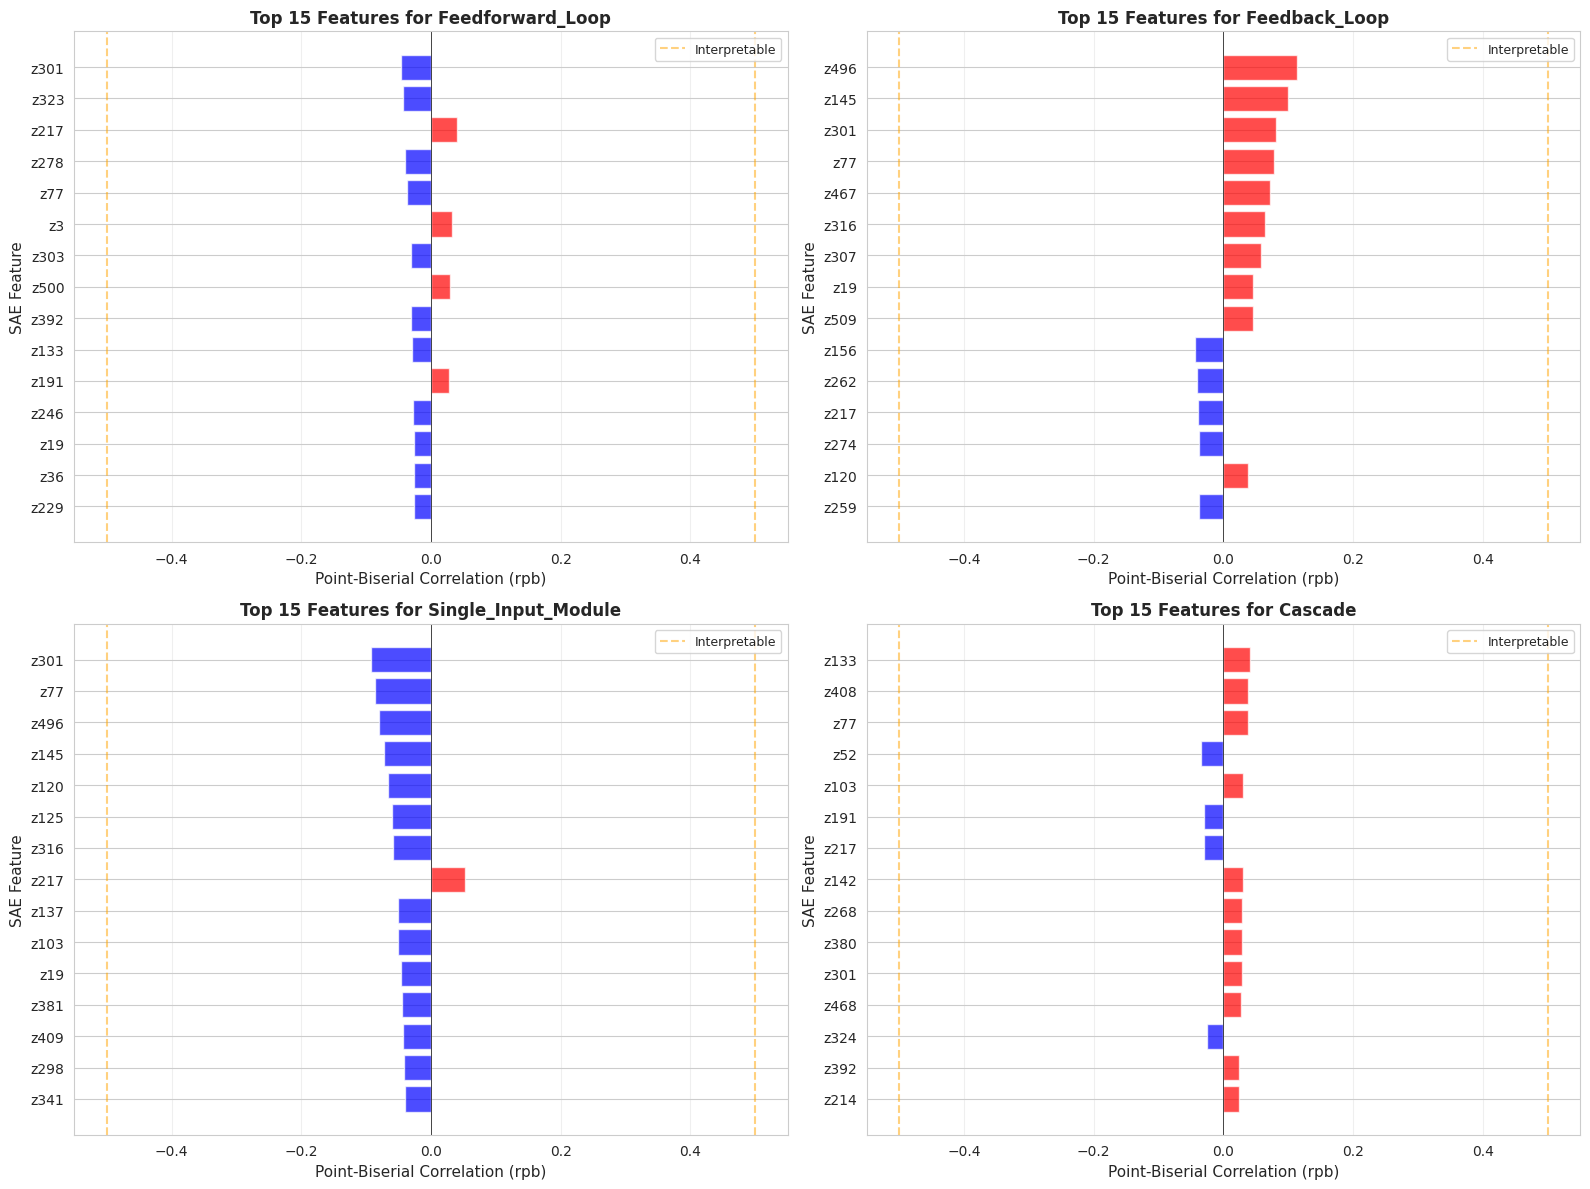

In [16]:
# Plot 6: Top features for each motif type
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, motif in enumerate(motif_types):
    ax = axes[idx]
    
    # Get top 15 features for this motif
    motif_corrs = df_corr[df_corr['motif'] == motif].nlargest(15, 'rpb_abs')
    
    # Create bar plot
    colors = ['red' if rpb > 0 else 'blue' for rpb in motif_corrs['rpb']]
    ax.barh(range(len(motif_corrs)), motif_corrs['rpb'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(motif_corrs)))
    ax.set_yticklabels(motif_corrs['feature'])
    ax.set_xlabel('Point-Biserial Correlation (rpb)', fontsize=11)
    ax.set_ylabel('SAE Feature', fontsize=11)
    ax.set_title(f'Top 15 Features for {motif.replace("in_", "").title()}', 
                 fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=INTERPRETABLE_THRESHOLD, color='orange', linestyle='--', 
               linewidth=1.5, alpha=0.5, label='Interpretable')
    ax.axvline(x=-INTERPRETABLE_THRESHOLD, color='orange', linestyle='--', 
               linewidth=1.5, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('outputs/top_features_per_motif.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Summary Tables and Export

In [17]:
# Create comprehensive summary table
summary_results = []

# For each feature, get its top motif correlation and related metrics
for feature in latent_features:
    feature_corrs = corr_matrix.loc[feature].abs()
    
    # Skip features with all NaN correlations
    if feature_corrs.isna().all():
        continue
    
    max_corr = feature_corrs.max(skipna=True)
    max_motif = feature_corrs.idxmax(skipna=True)
    
    # Skip if max is still NaN
    if pd.isna(max_corr) or pd.isna(max_motif):
        continue
    
    # Get correlation value (with sign)
    corr_value = corr_matrix.loc[feature, max_motif]
    
    # Get MI for this feature-motif pair
    mi_value = mi_matrix.loc[feature, max_motif]
    
    # Get precision/recall if available
    pr_row = df_pr[(df_pr['feature'] == feature) & (df_pr['motif'] == max_motif)]
    if len(pr_row) > 0:
        precision = pr_row.iloc[0]['precision']
        recall = pr_row.iloc[0]['recall']
        f1 = pr_row.iloc[0]['f1_score']
    else:
        precision, recall, _ = compute_precision_recall(df, feature, max_motif)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Check other motifs
    other_corrs = feature_corrs.drop(max_motif)
    max_other = other_corrs.max(skipna=True)
    if pd.isna(max_other):
        max_other = 0.0
    
    # Classify
    is_interpretable = (max_corr > INTERPRETABLE_THRESHOLD) and (max_other < OTHER_MOTIF_THRESHOLD)
    is_monosemantic = (max_corr > MONOSEMANTIC_THRESHOLD) and (max_other < OTHER_MOTIF_THRESHOLD)
    
    summary_results.append({
        'feature': feature,
        'top_motif': max_motif,
        'rpb': corr_value,
        'rpb_abs': max_corr,
        'mutual_info': mi_value,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'max_other_rpb': max_other,
        'interpretable': is_interpretable,
        'monosemantic': is_monosemantic
    })

df_summary = pd.DataFrame(summary_results)

# Sort by absolute correlation
df_summary = df_summary.sort_values('rpb_abs', ascending=False)

# Save summary
df_summary.to_csv('outputs/feature_motif_summary.csv', index=False)
print(f"✓ Saved comprehensive summary to outputs/feature_motif_summary.csv")

print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")
print(f"\nTotal nodes analyzed: {len(df):,}")
print(f"Total features: {len(latent_features)}")
print(f"Features with valid data: {len(df_summary)}")
print(f"Interpretable features: {df_summary['interpretable'].sum()}")
print(f"Monosemantic features: {df_summary['monosemantic'].sum()}")

print(f"\nTop 20 features by correlation:")
print(df_summary.head(20)[['feature', 'top_motif', 'rpb', 'mutual_info', 'precision', 'recall', 'interpretable', 'monosemantic']])

✓ Saved comprehensive summary to outputs/feature_motif_summary.csv

FINAL SUMMARY

Total nodes analyzed: 5,000
Total features: 512
Features with valid data: 156
Interpretable features: 0
Monosemantic features: 0

Top 20 features by correlation:
    feature               top_motif       rpb  mutual_info  precision  \
152    z496        in_feedback_loop  0.114268     0.011700   0.448000   
48     z145        in_feedback_loop  0.100054     0.004748   0.404000   
98     z301  in_single_input_module -0.093109     0.006912   0.084000   
25      z77  in_single_input_module -0.085762     0.006111   0.092000   
142    z467        in_feedback_loop  0.072154     0.006308   0.336000   
39     z120  in_single_input_module -0.065542     0.004562   0.096000   
101    z316        in_feedback_loop  0.064127     0.002970   0.360000   
41     z125  in_single_input_module -0.060150     0.003193   0.124000   
100    z307        in_feedback_loop  0.058770     0.025372   0.376000   
68     z217  in_single_in

In [18]:
# Print interpretable/monosemantic features grouped by motif
print(f"\n{'='*60}")
print("INTERPRETABLE FEATURES BY MOTIF")
print(f"{'='*60}")

for motif in motif_types:
    motif_features = df_summary[(df_summary['top_motif'] == motif) & (df_summary['interpretable'] == True)]
    mono_features = df_summary[(df_summary['top_motif'] == motif) & (df_summary['monosemantic'] == True)]
    
    print(f"\n{motif.replace('in_', '').upper()}:")
    print(f"  Interpretable: {len(motif_features)}")
    print(f"  Monosemantic: {len(mono_features)}")
    
    if len(mono_features) > 0:
        print(f"  Top monosemantic features:")
        for _, row in mono_features.nlargest(5, 'rpb_abs').iterrows():
            print(f"    {row['feature']}: rpb={row['rpb']:.3f}, MI={row['mutual_info']:.4f}, P={row['precision']:.3f}, R={row['recall']:.3f}")


INTERPRETABLE FEATURES BY MOTIF

FEEDFORWARD_LOOP:
  Interpretable: 0
  Monosemantic: 0

FEEDBACK_LOOP:
  Interpretable: 0
  Monosemantic: 0

SINGLE_INPUT_MODULE:
  Interpretable: 0
  Monosemantic: 0

CASCADE:
  Interpretable: 0
  Monosemantic: 0


## 9. Conclusions

This analysis evaluated whether SAE latent features correspond to canonical graph motifs using:

1. **Point-biserial correlation** - Linear relationship between continuous features and binary motif labels
2. **Precision/Recall** - Specificity and coverage of features for motifs
3. **Mutual Information** - Nonlinear dependencies as validation

Features were classified as:
- **Interpretable**: rpb > 0.5 for one motif, < 0.2 for others
- **Monosemantic**: rpb > 0.7 for one motif, < 0.2 for others (one-to-one correspondence)

Results show whether the SAE successfully learned to decompose GNN representations into interpretable motif-specific features.